In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objs as go

import data_preprocessing as dp
import geopandas as gpd

In [4]:
years = range(2020, 2024)
data_list = []

# Schleife über jedes Jahr
for year in years:
    df = pd.read_csv(f"MVG_Rad_Fahrten_{year}.csv", sep=";", decimal=",", parse_dates=["STARTTIME       ", "ENDTIME         "])
    
    # Entfernen von Leerzeichen in den Columns
    column_names = [dp.remove_space(column) for column in df.columns]
    df.columns = column_names

    # Hinzufügen des eingelesenen DataFrames zur Liste
    data_list.append(df)

# alle Daten zu einem einzigen DataFrame kombinieren 
df = pd.concat(data_list, ignore_index=True)

C:\Users\dsi\AppData\Local\Temp\ipykernel_33304\1466124582.py:6: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"MVG_Rad_Fahrten_{year}.csv", sep=";", decimal=",", parse_dates=["STARTTIME       ", "ENDTIME         "])
C:\Users\dsi\AppData\Local\Temp\ipykernel_33304\1466124582.py:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"MVG_Rad_Fahrten_{year}.csv", sep=";", decimal=",", parse_dates=["STARTTIME       ", "ENDTIME         "])
C:\Users\dsi\AppData\Local\Temp\ipykernel_33304\1466124582.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"MVG_Rad_Fahrten_{year}.csv", sep=";", decimal=",", parse_dates=["STARTTIME       ", "ENDTIME         "])


## Data Information

In [5]:
df.head()

,Row,STARTTIME,ENDTIME,STARTLAT,STARTLON,ENDLAT,ENDLON,RENTAL_IS_STATION,RENTAL_STATION_NAME,RETURN_IS_STATION,RETURN_STATION_NAME
0,1,2020-01-01 00:10:00,2020-01-01 00:21:00,48.16957,11.58736,48.16568,11.56474,0,,0,
1,2,2020-01-01 00:14:00,2020-01-01 00:32:00,48.13652,11.5929,48.13502,11.57901,0,,0,
2,3,2020-01-01 00:25:00,2020-01-01 00:41:00,48.1706,11.54881,48.16562,11.5648,0,,0,
3,4,2020-01-01 00:29:00,2020-01-01 00:43:00,48.17433,11.56033,48.17326,11.59075,0,,0,
4,5,2020-01-01 00:29:00,2020-01-01 00:30:00,48.12354,11.53372,48.12374,11.53319,0,,0,


In [6]:
df.columns

Index(['Row', 'STARTTIME', 'ENDTIME', 'STARTLAT', 'STARTLON', 'ENDLAT',
       'ENDLON', 'RENTAL_IS_STATION', 'RENTAL_STATION_NAME',
       'RETURN_IS_STATION', 'RETURN_STATION_NAME'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760575 entries, 0 to 2760574
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Row                  int64         
 1   STARTTIME            datetime64[ns]
 2   ENDTIME              datetime64[ns]
 3   STARTLAT             object        
 4   STARTLON             object        
 5   ENDLAT               object        
 6   ENDLON               object        
 7   RENTAL_IS_STATION    object        
 8   RENTAL_STATION_NAME  object        
 9   RETURN_IS_STATION    object        
 10  RETURN_STATION_NAME  object        
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 231.7+ MB


## Data Feintuning

### Entfernen von Leerzeichen

In [8]:
# Entfernen von Leerzeichen bei Stationsnamen
df["RENTAL_STATION_NAME"] = df["RENTAL_STATION_NAME"].apply(dp.remove_space)
df["RETURN_STATION_NAME"] = df["RETURN_STATION_NAME"].apply(dp.remove_space)

### Formatieren von Daten als Datetime

In [9]:
# STARTTIME und ENDTIME als datetime
df = dp.to_datetime(df)

### Löschen unnötiger Spalten

In [10]:
# Löschen von "Row"
df = df.drop("Row", axis=1)

### Optimierung der Koordinaten

In [11]:
# Formatierung der Koordinaten
# Entfernung ungültiger Daten
df = dp.handle_coordinates(df)

### Optimierung der Spalten IS_STATION

In [12]:
# Formatierung von is_station
df = dp.handle_is_station(df)
# Befüllen von is_station, je nachdem, ob Station Name vorhanden
df = dp.fill_is_station_values(df)

Formatierung nicht möglich, setze Wert auf NA: NULL             
Formatierung nicht möglich, setze Wert auf NA: NULL             
Formatierung nicht möglich, setze Wert auf NA: NULL             
Formatierung nicht möglich, setze Wert auf NA: NULL             
Formatierung nicht möglich, setze Wert auf NA: NULL             
Formatierung nicht möglich, setze Wert auf NA: NULL             
Formatierung nicht möglich, setze Wert auf NA: NULL             
Formatierung nicht möglich, setze Wert auf NA: NULL             
Formatierung nicht möglich, setze Wert auf NA: NULL             
Formatierung nicht möglich, setze Wert auf NA: NULL             


## Erneute Überprüfung

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760575 entries, 0 to 2760574
Data columns (total 10 columns):
 #   Column               Dtype         
---  ------               -----         
 0   STARTTIME            datetime64[ns]
 1   ENDTIME              datetime64[ns]
 2   STARTLAT             float64       
 3   STARTLON             float64       
 4   ENDLAT               float64       
 5   ENDLON               float64       
 6   RENTAL_IS_STATION    Int64         
 7   RENTAL_STATION_NAME  object        
 8   RETURN_IS_STATION    Int64         
 9   RETURN_STATION_NAME  object        
dtypes: Int64(2), datetime64[ns](2), float64(4), object(2)
memory usage: 215.9+ MB


In [14]:
for column in df.columns:
    print(f"Anzahl NA-Werte in {column}: {df[column].isna().sum()}")

Anzahl NA-Werte in STARTTIME: 0
Anzahl NA-Werte in ENDTIME: 0
Anzahl NA-Werte in STARTLAT: 19671
Anzahl NA-Werte in STARTLON: 19649
Anzahl NA-Werte in ENDLAT: 24819
Anzahl NA-Werte in ENDLON: 24799
Anzahl NA-Werte in RENTAL_IS_STATION: 0
Anzahl NA-Werte in RENTAL_STATION_NAME: 0
Anzahl NA-Werte in RETURN_IS_STATION: 0
Anzahl NA-Werte in RETURN_STATION_NAME: 0


## Ergänzung einer Spalte für die Dauer einer Fahrt

In [15]:
# Hinzufügen einer Spalte für die Dauer
df["DURATION"] = df["ENDTIME"] - df["STARTTIME"]

# Entfernen von ungültigen Datenpunkten
df = dp.remove_invalid_datetime(df)


## Entfernen aller Zeilen mit NAN-Werten, Sicherung des ursprünglichen DataFrames

In [16]:
# Achtung: Zu welchem Zeitpunkt soll dies hier geschehen?

df_with_NA_coordinates = df.copy()
df = df.dropna()

## Zeitreihenanalyse (mit Plotly & Prophet)
#Wie viele Fahrten täglich für MVG Rad?

In [ ]:
!pip install prophet

In [17]:
df

,STARTTIME,ENDTIME,STARTLAT,STARTLON,ENDLAT,ENDLON,RENTAL_IS_STATION,RENTAL_STATION_NAME,RETURN_IS_STATION,RETURN_STATION_NAME,DURATION
0,2020-01-01 00:10:00,2020-01-01 00:21:00,48.16957,11.58736,48.16568,11.56474,0,,0,,0 days 00:11:00
1,2020-01-01 00:14:00,2020-01-01 00:32:00,48.13652,11.59290,48.13502,11.57901,0,,0,,0 days 00:18:00
2,2020-01-01 00:25:00,2020-01-01 00:41:00,48.17060,11.54881,48.16562,11.56480,0,,0,,0 days 00:16:00
3,2020-01-01 00:29:00,2020-01-01 00:43:00,48.17433,11.56033,48.17326,11.59075,0,,0,,0 days 00:14:00
4,2020-01-01 00:29:00,2020-01-01 00:30:00,48.12354,11.53372,48.12374,11.53319,0,,0,,0 days 00:01:00
...,...,...,...,...,...,...,...,...,...,...,...
2760570,2023-12-31 23:52:00,2023-12-31 23:57:00,48.16719,11.55854,48.16917,11.55547,0,,0,,0 days 00:05:00
2760571,2023-12-31 23:52:00,2024-01-01 00:07:00,48.17061,11.57391,48.17334,11.55952,0,,0,,0 days 00:15:00
2760572,2023-12-31 23:53:00,2023-12-31 23:57:00,48.14131,11.56144,48.14094,11.56044,0,,0,,0 days 00:04:00
2760573,2023-12-31 23:54:00,2023-12-31 23:59:00,48.12353,11.54494,48.12674,11.54758,0,,0,,0 days 00:05:00


## Ergänzung einer Spalte für die Dauer einer Fahrt in Min

In [22]:
df['DURATION_MIN'] = np.round((df['DURATION']).dt.total_seconds() / 60)
df

,STARTTIME,ENDTIME,STARTLAT,STARTLON,ENDLAT,ENDLON,RENTAL_IS_STATION,RENTAL_STATION_NAME,RETURN_IS_STATION,RETURN_STATION_NAME,DURATION,DURATION_MIN
0,2020-01-01 00:10:00,2020-01-01 00:21:00,48.16957,11.58736,48.16568,11.56474,0,,0,,0 days 00:11:00,11.0
1,2020-01-01 00:14:00,2020-01-01 00:32:00,48.13652,11.59290,48.13502,11.57901,0,,0,,0 days 00:18:00,18.0
2,2020-01-01 00:25:00,2020-01-01 00:41:00,48.17060,11.54881,48.16562,11.56480,0,,0,,0 days 00:16:00,16.0
3,2020-01-01 00:29:00,2020-01-01 00:43:00,48.17433,11.56033,48.17326,11.59075,0,,0,,0 days 00:14:00,14.0
4,2020-01-01 00:29:00,2020-01-01 00:30:00,48.12354,11.53372,48.12374,11.53319,0,,0,,0 days 00:01:00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2760570,2023-12-31 23:52:00,2023-12-31 23:57:00,48.16719,11.55854,48.16917,11.55547,0,,0,,0 days 00:05:00,5.0
2760571,2023-12-31 23:52:00,2024-01-01 00:07:00,48.17061,11.57391,48.17334,11.55952,0,,0,,0 days 00:15:00,15.0
2760572,2023-12-31 23:53:00,2023-12-31 23:57:00,48.14131,11.56144,48.14094,11.56044,0,,0,,0 days 00:04:00,4.0
2760573,2023-12-31 23:54:00,2023-12-31 23:59:00,48.12353,11.54494,48.12674,11.54758,0,,0,,0 days 00:05:00,5.0


## Extrahieren von DATE / MIN / HOUR

In [24]:
#df ['DATE'] <- ['STARTTIME'] - Datum/Stunde/Wochentag extrahieren
df['DATE'] = df['STARTTIME'].dt.date #Datum extrahieren
df['MIN'] = df['STARTTIME'].dt.minute #Minute extrahieren
df['HOUR'] = df['STARTTIME'].dt.hour #Stunde extrahieren
df['WEEKDAY'] = df['STARTTIME'].dt.day_name #Wochentag extrahieren - Fehler?!

df

,STARTTIME,ENDTIME,STARTLAT,STARTLON,ENDLAT,ENDLON,RENTAL_IS_STATION,RENTAL_STATION_NAME,RETURN_IS_STATION,RETURN_STATION_NAME,DURATION,DURATION_MIN,DATE,MIN,HOUR,WEEKDAY
0,2020-01-01 00:10:00,2020-01-01 00:21:00,48.16957,11.58736,48.16568,11.56474,0,,0,,0 days 00:11:00,11.0,2020-01-01,10,0,<bound method PandasDelegate._add_delegate_acc...
1,2020-01-01 00:14:00,2020-01-01 00:32:00,48.13652,11.59290,48.13502,11.57901,0,,0,,0 days 00:18:00,18.0,2020-01-01,14,0,<bound method PandasDelegate._add_delegate_acc...
2,2020-01-01 00:25:00,2020-01-01 00:41:00,48.17060,11.54881,48.16562,11.56480,0,,0,,0 days 00:16:00,16.0,2020-01-01,25,0,<bound method PandasDelegate._add_delegate_acc...
3,2020-01-01 00:29:00,2020-01-01 00:43:00,48.17433,11.56033,48.17326,11.59075,0,,0,,0 days 00:14:00,14.0,2020-01-01,29,0,<bound method PandasDelegate._add_delegate_acc...
4,2020-01-01 00:29:00,2020-01-01 00:30:00,48.12354,11.53372,48.12374,11.53319,0,,0,,0 days 00:01:00,1.0,2020-01-01,29,0,<bound method PandasDelegate._add_delegate_acc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760570,2023-12-31 23:52:00,2023-12-31 23:57:00,48.16719,11.55854,48.16917,11.55547,0,,0,,0 days 00:05:00,5.0,2023-12-31,52,23,<bound method PandasDelegate._add_delegate_acc...
2760571,2023-12-31 23:52:00,2024-01-01 00:07:00,48.17061,11.57391,48.17334,11.55952,0,,0,,0 days 00:15:00,15.0,2023-12-31,52,23,<bound method PandasDelegate._add_delegate_acc...
2760572,2023-12-31 23:53:00,2023-12-31 23:57:00,48.14131,11.56144,48.14094,11.56044,0,,0,,0 days 00:04:00,4.0,2023-12-31,53,23,<bound method PandasDelegate._add_delegate_acc...
2760573,2023-12-31 23:54:00,2023-12-31 23:59:00,48.12353,11.54494,48.12674,11.54758,0,,0,,0 days 00:05:00,5.0,2023-12-31,54,23,<bound method PandasDelegate._add_delegate_acc...


## Fahrten pro Tag / pro Stunde

In [27]:
#Anzahl der Fahrten pro Tag
daily_counts = df.groupby('DATE').size().reset_index(name='DAILY_COUNTS')
print(daily_counts)

#Anzahl der Fahrten pro Stunde und Wochentag
hourly_counts = df.groupby(['WEEKDAY', 'HOUR']).size().reset_index(name='HOURLY_COUNTS')
print(hourly_counts)

#Wochentage sortieren - Fehler!
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_counts['WEEKDAY'] = pd.Categorical(hourly_counts['WEEKDAY'], categories=weekday_order, ordered=True)

            DATE  DAILY_COUNTS
0     2020-01-01           597
1     2020-01-02           680
2     2020-01-03           750
3     2020-01-04           562
4     2020-01-05           583
...          ...           ...
1456  2023-12-27           542
1457  2023-12-28           706
1458  2023-12-29           851
1459  2023-12-30           784
1460  2023-12-31           672

[1461 rows x 2 columns]
                                              WEEKDAY  HOUR  HOURLY_COUNTS
0   <bound method PandasDelegate._add_delegate_acc...     0          46518
1   <bound method PandasDelegate._add_delegate_acc...     1          37872
2   <bound method PandasDelegate._add_delegate_acc...     2          26546
3   <bound method PandasDelegate._add_delegate_acc...     3          16795
4   <bound method PandasDelegate._add_delegate_acc...     4          10826
5   <bound method PandasDelegate._add_delegate_acc...     5          11753
6   <bound method PandasDelegate._add_delegate_acc...     6          27904
7  

In [51]:
#Linienplot der täglichen Anzahl der Fahrten
fig_daily = px.line(
    daily_counts, 
    x='DATE', 
    y='DAILY_COUNTS', 
    title='Tägliche Anzahl der Fahrten (2020-2023)', 
    labels={'DAILY_COUNTS': 'Fahrten', 'DATE': 'Datum'},
    template="plotly_white"
)

#Titel in die Mitte setzen
fig_daily.update_layout(
    title={
        'text': "Tägliche Anzahl der Fahrten (2020-2023)",
        'y': 0.9,  #Y-Position des Titels
        'x': 0.5,  #X-Position des Titels (zentriert)
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    }
)

fig_daily.show()

## Prognose mit Prophet

22:40:02 - cmdstanpy - INFO - Chain [1] start processing
22:40:02 - cmdstanpy - INFO - Chain [1] done processing


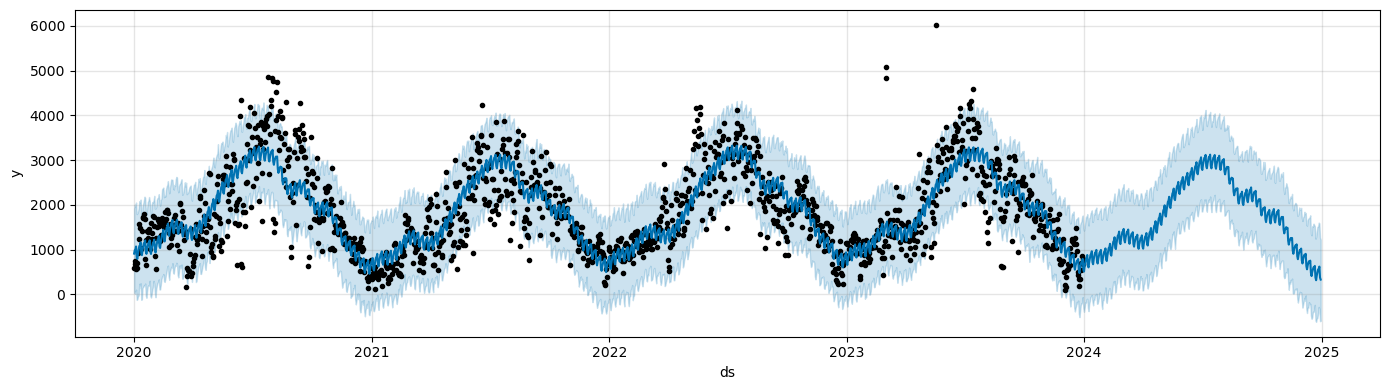

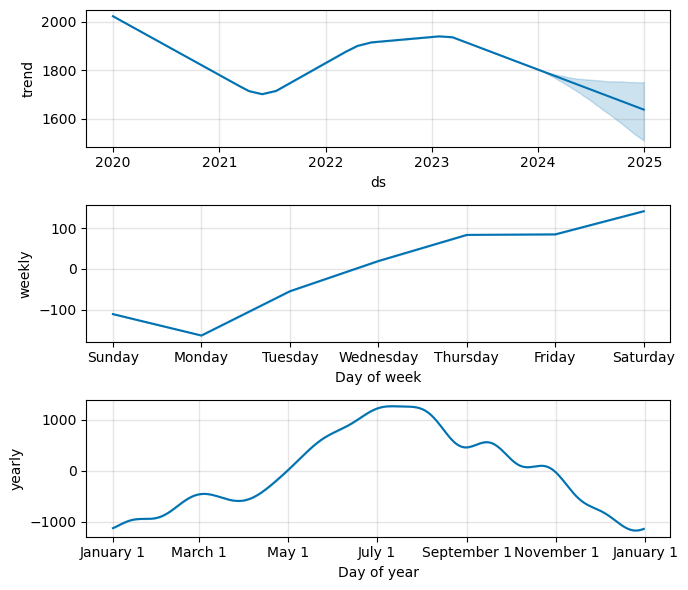

In [34]:
#Daten für Prophet vorbereiten
prophet_data = daily_counts.rename(columns={'DATE': 'ds', 'DAILY_COUNTS': 'y'})

#Prophet-Modell initialisieren und trainieren
model = Prophet(growth='linear', seasonality_mode='additive', interval_width=0.90)
model.fit(prophet_data)

#Zukunftsdaten erstellen
future = model.make_future_dataframe(periods=365, freq='D', include_history=True)  #Prognose für ein Jahr
#future.tail()

forecast = model.predict(future)
#forecast.tail()

#Prognose visualisieren
fig_forecast = model.plot(forecast, figsize=(14, 4))
fig_components = model.plot_components(forecast, figsize=(7, 6))

## Prognose mit Plotly

In [42]:
pip install ipywidgets

In [43]:
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [47]:
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objs as go
plot_plotly(model, forecast)

In [48]:
plot_components_plotly(model, forecast)

## Fahrten pro Stunde

In [39]:
#Anzahl der Fahrten pro Stunde
hourly_counts = df.groupby('HOUR').size().reset_index(name='HOURLY_COUNTS')

fig_hourly = px.line(
    hourly_counts, 
    x='HOUR', 
    y='HOURLY_COUNTS', 
    title='Stündliche Anzahl der Fahrten (2020-2023)', 
    labels={'HOURLY_COUNTS': 'Fahrten', 'HOUR': 'Stunde des Tages'},
    template="plotly_white"
)

fig_hourly.update_traces(mode='lines+markers')

#Titel in die Mitte setzen
fig_hourly.update_layout(
    title={
        'text': "Stündliche Anzahl der Fahrten (2020-2023)",
        'y': 0.9,  #Y-Position des Titels
        'x': 0.5,  #X-Position des Titels (zentriert)
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig_hourly.show()

In [40]:
df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2717505 entries, 0 to 2760574
Data columns (total 16 columns):
 #   Column               Dtype          
---  ------               -----          
 0   STARTTIME            datetime64[ns] 
 1   ENDTIME              datetime64[ns] 
 2   STARTLAT             float64        
 3   STARTLON             float64        
 4   ENDLAT               float64        
 5   ENDLON               float64        
 6   RENTAL_IS_STATION    Int64          
 7   RENTAL_STATION_NAME  object         
 8   RETURN_IS_STATION    Int64          
 9   RETURN_STATION_NAME  object         
 10  DURATION             timedelta64[ns]
 11  DURATION_MIN         float64        
 12  DATE                 object         
 13  MIN                  int32          
 14  HOUR                 int32          
 15  WEEKDAY              object         
dtypes: Int64(2), datetime64[ns](2), float64(5), int32(2), object(4), timedelta64[ns](1)
memory usage: 401.4+ MB


Frage: Wie lange mieten die Leute die Fahrräder?

               Count
DURATION_MIN        
0-2 min        73541
2-5 min       367006
5-10 min      747212
10-15 min     537997
15-30 min     652548
30-60 min     207552
1-4h           92395
4h-1day        29335
1day+           5856


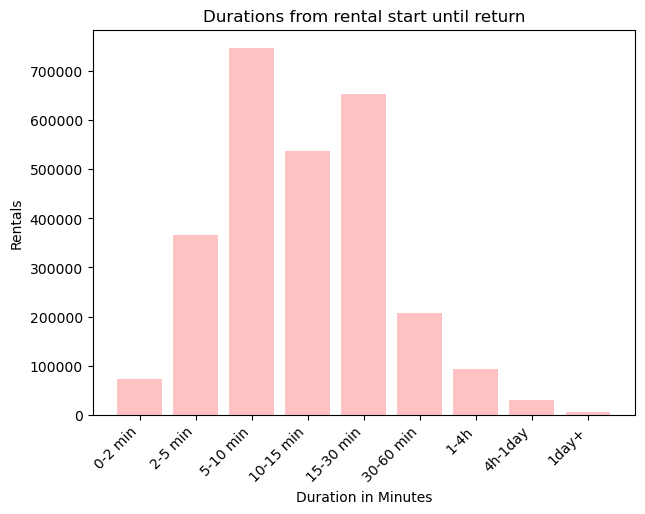

In [41]:
#Create a histogram as table
#Define the bin edges and labels
bin_edges = [0, 2, 5, 10, 15, 30, 60, 240, 1440, np.inf]
bin_labels = ['0-2 min','2-5 min', '5-10 min', '10-15 min', '15-30 min', '30-60 min', '1-4h', '4h-1day', '1day+']

#Create a new column with the binned values
df['DURATION_MIN'] = pd.cut(df['DURATION_MIN'], bins=bin_edges, labels=bin_labels)
duration_value_counts = df['DURATION_MIN'].value_counts()

#Convert the value counts to a dataframe and sort by index
duration_histogram_df = pd.DataFrame({'Count': duration_value_counts}).sort_index()
print(duration_histogram_df)

#Create the histogram using Matplotlib
plt.figure(figsize=(7,5))
plt.bar(duration_histogram_df.index, duration_histogram_df['Count'], color='#FFC2C4')

#Set the title and axis labels
plt.title('Durations from rental start until return')
plt.xlabel('Duration in Minutes')
plt.ylabel('Rentals')

#Set the x-axis tick labels to the bin labels
plt.xticks(rotation=45, ha='right')

#Show the plot
plot = plt.plot()

Überlegung über DURATION < 0 / = 0 / > 1 Tag

In [ ]:
#DataFrame 2020-2023
df20 = df[df['STARTTIME'].dt.year == 2020].copy()
df21 = df[df['STARTTIME'].dt.year == 2021].copy()
df22 = df[df['STARTTIME'].dt.year == 2022].copy()
df23 = df[df['STARTTIME'].dt.year == 2023].copy()

In [ ]:
#Fahrtdauer in Minuten berechnen & runden 
df20['DURATION_MIN'] = np.round((df['DURATION']).dt.total_seconds() / 60)
df21['DURATION_MIN'] = np.round((df['DURATION']).dt.total_seconds() / 60)
df22['DURATION_MIN'] = np.round((df['DURATION']).dt.total_seconds() / 60)
df23['DURATION_MIN'] = np.round((df['DURATION']).dt.total_seconds() / 60)
#df20['DURATION_MIN'].describe()

In [ ]:
#DURATION_MIN <= 0
duration_negative_count = df20[df20['DURATION_MIN'] < 0].shape[0]
print(f"duration_negative_count: {duration_negative_count}")

duration_zero_count = df20[df20['DURATION_MIN'] == 0].shape[0]
print(f"duration_zero_count: {duration_zero_count}")

#df20
#2020 (< 0): 7; (= 0): 1404; Total 1411
#2021 (< 0): 14; (= 0): 1123; Total 1137
#2022 (< 0): 22; (= 0): 866; Total 888
#2023 (< 0): 14; (= 0): 670; Total 684

duration_negative_count: 0
duration_zero_count: 1404


In [ ]:
#DURATION_MIN > 1440
duration_overday_count = df20[df20['DURATION_MIN'] > 1440].shape[0]
print(f"duration_overday_count: {duration_overday_count}")

#2020 (> 1440) 1040
#2021 (> 1440) 1359
#2022 (> 1440) 2154
#2023 (> 1440) 1303

duration_overday_count: 1040


Funktion-Backup & calculate_distance_km

In [ ]:
#2 Funktion Leerzeichenentfernung (Columns & RENTAL_STATION_NAME & RETURN_STATION_NAME)
def remove_space(string: str) -> str:
    if isinstance(string, str):
        return string.strip()
    else:
        return string

In [ ]:
#5 Funktion
def to_datetime(df: pd.DataFrame, column_start: str = "STARTTIME", column_end: str = "ENDTIME") -> pd.DataFrame:
    #> datetime; ungültige Einträge: NaT 
    df[column_start] = pd.to_datetime(df[column_start], errors='coerce')
    df[column_end] = pd.to_datetime(df[column_end], errors='coerce')

    return df

In [ ]:
# Funktion zur Entfernung von Datetime
def remove_invalid_datetime(df: pd.DataFrame, column_start: str = "STARTTIME", column_end: str = "ENDTIME") -> pd.DataFrame:
    """
    Removes invalid (STARTTIME and ENDTIME)

    Parameters:
    -df(pd.DataFrame): Input DataFrame.
    -column_start(str): Name of column for start time.
    -column_end(str): Name of column for end time.

    Returns:
    pd.DataFrame: Cleaned DataFrame with validated dates.
    """
    #Entferne Zeilen, bei denen ENDTIME < STARTTIME oder einer von beiden NaT ist
    df = df[df[column_end] >= df[column_start]]
    df = df.dropna(subset=[column_start, column_end])

    return df

In [ ]:
# Mit geopandas für coordinates-km conversion
import geopandas as gpd

def calculate_distance_km(df: pd.DataFrame) -> gpd.GeoDataFrame:
    """
    Adds geospatial points and calculates distances between them in kilometers.

    Parameters:
    df(pd.DataFrame): DataFrame with columns 'STARTLON', 'STARTLAT', 'ENDLON', 'ENDLAT'.

    Returns:
    gpd.GeoDataFrame: a GeoDataFrame column 'DISTANCE_KM'.
    """
    # Geometrien hinzufügen
    df['START_POINT'] = gpd.points_from_xy(df['STARTLON'], df['STARTLAT'])
    df['END_POINT'] = gpd.points_from_xy(df['ENDLON'], df['ENDLAT'])

    # Konvertiere den DataFrame zu einem GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='START_POINT')

    # CRS auf WGS 84 setzen und in ein metrisches CRS transformieren
    gdf = gdf.set_crs(epsg=4326)  # WGS 84
    gdf = gdf.to_crs(epsg=3857)   # Meter-Projektion

    # Distanzen berechnen (in Metern) und in Kilometer umrechnen
    gdf['DISTANCE_KM'] = gdf.apply(lambda row: row['START_POINT'].distance(row['END_POINT']) / 1000, axis=1)

    return gdf[['DISTANCE_KM']]

In [ ]:
#!pip install folium

   ---------------------------------------- 0.0/110.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/110.1 kB ? eta -:--:--
   ---------- ---------------------------- 30.7/110.1 kB 217.9 kB/s eta 0:00:01
   ------------------ -------------------- 51.2/110.1 kB 327.7 kB/s eta 0:00:01
   -------------------------------- ------ 92.2/110.1 kB 435.7 kB/s eta 0:00:01
   -------------------------------------- 110.1/110.1 kB 492.1 kB/s eta 0:00:00


In [ ]:
#!pip install streamlit-folium

   ---------------------------------------- 0.0/328.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/328.1 kB ? eta -:--:--
   - -------------------------------------- 10.2/328.1 kB ? eta -:--:--
   --- ----------------------------------- 30.7/328.1 kB 262.6 kB/s eta 0:00:02
   -------------- ----------------------- 122.9/328.1 kB 901.1 kB/s eta 0:00:01
   ------------------------------------- -- 307.2/328.1 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 328.1/328.1 kB 1.6 MB/s eta 0:00:00
